In [1]:
# install python-metar
# git clone https://github.com/python-metar/python-metar
# cd python-metar
# python setup.py install

# ? https://www.openwindmap.org/
# ? https://www.blitzortung.org
# ? https://publicwiki.meteo.fr/download/attachments/12650095/Pr%C3%A9sentation%20CSM%20-%20Observation%20participative.pdf?version=1&modificationDate=1495535265741&api=v2
# ? https://caspa.sciencesconf.org/data/0204.pdf
# ? https://www.weatherlink.com


## Imports

In [3]:
#from __future__ import print_function
#
#import os
#import sys
#import getopt
#import string
import pandas as pd
import geopandas as gpd
import requests
import plotly.express as px
import traceback
#
#try:
#    from urllib2 import urlopen
#except:
#    from urllib.request import urlopen
from metar import Metar
from urllib.request import urlopen
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime
import numpy as np

# https://stackoverflow.com/questions/41190989/how-do-i-install-geckodriver
# https://stackoverflow.com/questions/46809135/webdriver-exceptionprocess-unexpectedly-closed-with-status-1
# pip install webdrivermanager
# sudo apt-get install firefox
# webdrivermanager firefox --linkpath /usr/local/bin
# sudo apt install firefox-geckodriver

from selenium import webdriver
from time import sleep
from selenium.webdriver import FirefoxOptions

#import re
import cv2 
import pytesseract
#from pytesseract import Output
from matplotlib import pyplot as plt
from io import StringIO
from datetime import datetime as dt



# https://trangthuyvo.wordpress.com/2019/12/03/crowdsourcing-weather-data-from-netatmo-weathermap/
#import time
#import os 
#import datetime
#from datetime import datetime   
import patatmo

## Fonctions

In [4]:
def download_ourairports_data():
    # on liste les aéroports dans les limites de l'extent
    # basé sur https://ourairports.com/data/, documentation à https://ourairports.com/help/data-dictionary.html
    """_summary_
    """
    print("- downloading OurAirports data...")
    URL = "https://davidmegginson.github.io/ourairports-data/airports.csv"
    response = requests.get(URL)
    open("./data/airports.csv", "wb").write(response.content)



def select_airports(lat_sw, lon_sw, lat_ne, lon_ne):
    """_summary_

    Args:
        lat_sw (_type_): _description_
        lon_sw (_type_): _description_
        lat_ne (_type_): _description_
        lon_ne (_type_): _description_
    """
    print("- filtering OurAirports data according to query ROI and IACO code availability...")
    df_airports = pd.read_csv('./data/airports.csv')
    df_airports = gpd.GeoDataFrame(df_airports, geometry=gpd.points_from_xy(df_airports.longitude_deg, df_airports.latitude_deg))
    df_airports.crs = 'epsg:4326'

    # we keep only airports inside the ROI and that have a IACO-like code
    condition = (df_airports["latitude_deg"]>lat_sw) & (df_airports["latitude_deg"]<lat_ne) & (df_airports["longitude_deg"]>lon_sw) & (df_airports["longitude_deg"]<lon_ne) & (-pd.isna(df_airports["gps_code"]))
    df_airports_study_zone = df_airports[condition].reset_index(drop=True)

    return df_airports_study_zone



def query_metar(stations, verbose=False):
    """_summary_

    Args:
        stations (_type_): _description_

    Returns:
        _type_: _description_
    """
    print("- Querying METAR...")
    BASE_URL = "http://tgftp.nws.noaa.gov/data/observations/metar/stations"
    metar_df = pd.DataFrame()

    for name in stations:
        try:
            url = "%s/%s.TXT" % (BASE_URL, name)
            try:
                urlh = urlopen(url)
                report = ""
                for line in urlh:
                    if not isinstance(line, str):
                        line = line.decode()  # convert Python3 bytes buffer to string
                    if line.startswith(name):
                        report = line.strip()
                        obs = Metar.Metar(line)
                        metar_df = metar_df.append(pd.DataFrame({"airport":obs.station_id, "time":obs.time, "temp":obs.temp},index=[0]))
                        if verbose: print(line.strip("\n"))
                        break
                if not report:
                    if verbose:print(name,": no data in METAR")
            except Metar.ParserError as exc:
                if verbose: print(name,": parser error - line content was :", line.strip("\n"))
                # print(string.join(exc.args, ", "), "\n")
            except:
                if verbose: print(name,": error retrieving data")
                # print(traceback.format_exc())
        except:
            if verbose: print(name,": uncaught issue")
            # print(traceback.format_exc())

    # on convertit la température en float
    def temp_value(x):
        try:
            return x.value()
        except:
            return np.nan

    metar_df["temp"] = metar_df.apply(lambda x: temp_value(x["temp"]), axis=1)
    metar_df = metar_df.reset_index(drop=True)

    # on formatte le dataframe metar_df_coords, on ne filtre pour conserver que les METAR de l'heure
    metar_df_coords = metar_df.merge(df_airports_study_zone[["name","latitude_deg","longitude_deg", "gps_code"]], left_on='airport', right_on='gps_code')
    metar_df_coords["delay_last_obs_days"] = metar_df_coords.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).days, axis=1)
    metar_df_coords["delay_last_obs_hours"] = metar_df_coords.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).seconds//3600, axis=1)
    metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_days"]==0]
    metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_hours"]<1]
    metar_df_coords = metar_df_coords.drop(columns=["delay_last_obs_days","delay_last_obs_hours"]).dropna()
    metar_df_coords = metar_df_coords.rename(columns={"airport":"id"})
    metar_df_coords["data_source"]="METAR"
        
    return metar_df_coords



def get_LMI_TREMA_data():
    """_summary_

    Returns:
        _type_: _description_
    """
    # on réalise la copie d'écran de la page affichant les données
    print("- taking LMI TREMA weather station webpage screenshot...")
    opts = FirefoxOptions()
    opts.add_argument("--headless")

    driver = webdriver.Firefox(options=opts)
    driver.set_window_size(900, 900)
    driver.get('http://trema.ucam.ac.ma/Obs_TREMA/index.html')
    sleep(10)

    driver.get_screenshot_as_file("./data/screenshot_LMI_TREMA.png")
    driver.quit()

    image = cv2.imread('./data/screenshot_LMI_TREMA.png')
    #image = cv2.imread('./data/screenshot_LMI_TREMA.png')
    #b,g,r = cv2.split(image)
    #rgb_img = cv2.merge([r,g,b])
    #plt.imshow(rgb_img)
    #plt.show()

    # Get OCR output using Pytesseract
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(image, config=custom_config)
    text = StringIO(text)
    df_parse_lmi = pd.read_csv(text, sep="  ")

    # on parse la lecture OCR
    df_parse_lmi = df_parse_lmi[5:].reset_index(drop=True) # on drop les 5 premières lignes
    df_parse_lmi=df_parse_lmi.rename(columns={df_parse_lmi.columns[0]:"values"}) # on renomme la colonne

    for i in range(len(df_parse_lmi)) :
        try:
            df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i, "values"].split(" ")[-1])
            df_parse_lmi.loc[i,"hour"] = df_parse_lmi.loc[i, "values"].split(" ")[-2]
            df_parse_lmi.loc[i,"date"] = df_parse_lmi.loc[i, "values"].split(" ")[-3]
            df_parse_lmi.loc[i,"time"] = dt.strptime(df_parse_lmi.loc[i,"hour"]+" "+ df_parse_lmi.loc[i,"date"], "%H:%M:%S %d/%m/%Y")
            df_parse_lmi.loc[i,"station"] = ' '.join(df_parse_lmi.loc[i,"values"].split()[0:-3])
            
        except:
            # print(traceback.format_exc())
            pass

    df_parse_lmi = df_parse_lmi.drop(columns=["values","hour","date"]).dropna().reset_index(drop=True)

    # on corrige le doublon en virant la seconde station ouka
    df_stations = pd.read_csv("./data/stations_LMI_TREMA.csv", sep=";")
    df_parse_lmi = df_parse_lmi.merge(df_stations, left_on="station", right_on="station")
    df_parse_lmi["name"]=df_parse_lmi["station"]
    df_parse_lmi["data_source"]="LMI_TREMA"

    return df_parse_lmi




def filter_last_cycle(df):
    df["delay_last_obs_days"] = df.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).days, axis=1)
    df["delay_last_obs_hours"] = df.apply(lambda x: (datetime.datetime.utcnow() - x["time"]).seconds//3600, axis=1)
    df = df[df["delay_last_obs_days"]==0]
    df = df[df["delay_last_obs_hours"]<1]
    df = df.drop(columns=["delay_last_obs_days","delay_last_obs_hours"])
    df = df.rename(columns={"airport":"id"})
    df = df.reset_index(drop=True)
    return df



def get_NETATMO_data(lat_sw, lon_sw, lat_ne, lon_ne, full=False):
    print("- Querying NETATMO open data...")
    # Define your netatmo connect developer credentials
    credentials = {
        "password":"22*ljWUgzIU^",
        "username":"jeremy.lavarenne@yahoo.com",
        "client_id":    "62913128aa50e27639606fdf",
        "client_secret":"bUZWPCmEEjKW8p1ttQDWALIU5w"
        }

    # configure the authentication
    authentication = patatmo.api.authentication.Authentication(
        credentials=credentials,
        tmpfile = "temp_auth.json")

    # create an api client
    client = patatmo.api.client.NetatmoClient(authentication)

    region = {
            "lat_ne": lat_ne,
            "lat_sw": lat_sw,
            "lon_ne": lon_ne,
            "lon_sw": lon_sw,
            }
        
    # issue the API request for getting public data
    netatmo = client.Getpublicdata(region = region, full=full, filter=False)

    #convert the public data to pandas DataFrame
    df_netatmo = netatmo.dataframe()

    df_netatmo = df_netatmo.rename(columns={"latitude":"latitude_deg", "longitude":"longitude_deg", "time_temperature":"time","temperature":"temp"}).reset_index(drop=True)
    df_netatmo["time"] = df_netatmo.apply(lambda x: x["time"].to_pydatetime().replace(tzinfo=None), axis=1)
    df_netatmo["name"] = df_netatmo["id"]

    condition = (df_netatmo["latitude_deg"]>lat_sw) & (df_netatmo["latitude_deg"]<lat_ne) & (df_netatmo["longitude_deg"]>lon_sw) & (df_netatmo["longitude_deg"]<lon_ne)
    df_netatmo = df_netatmo[condition]
    df_netatmo["data_source"]="NETATMO"
    df_netatmo = df_netatmo[["name","longitude_deg","latitude_deg","time","temp","data_source"]]

    return df_netatmo


# Loop

In [49]:
# délimitation de l'extent dans lequel on veut récupérer les données
# encadrement large du Maroc sans Sahara Occidental
lat_ne = 36.0
lon_ne = 0.8
lat_sw = 26.5
lon_sw = -15.1

download_ourairports_data()
df_airports_study_zone = select_airports(lat_sw, lon_sw, lat_ne, lon_ne)
# on requete les METAR
stations = df_airports_study_zone["gps_code"]
metar_df_coords = query_metar(stations)
metar_df_coords = filter_last_cycle(metar_df_coords)

# on requête les données LMI TREMA
#df_parse_lmi = get_LMI_TREMA_data()
#df_parse_lmi = filter_last_cycle(df_parse_lmi)

# on requête les données NETATMO
df_netatmo = get_NETATMO_data(lat_sw, lon_sw, lat_ne, lon_ne, full=False)
df_netatmo = filter_last_cycle(df_netatmo)

df_measures_cycle = pd.DataFrame()
df_measures_cycle = df_measures_cycle.append(metar_df_coords)
#df_measures_cycle = df_measures_cycle.append(df_parse_lmi)
df_measures_cycle = df_measures_cycle.append(df_netatmo)

# on exporte les mesures du cycle en cours pour production des cartes
gdf_measures_cycle = gpd.GeoDataFrame(df_measures_cycle.drop(columns="time"), geometry=gpd.points_from_xy(df_measures_cycle.longitude_deg, df_measures_cycle.latitude_deg))
gdf_measures_cycle.crs = 'epsg:4326'
gdf_measures_cycle.to_file("./data/gdf_measures_cycle.shp")


- downloading OurAirports data...
- filtering OurAirports data according to query ROI and IACO code availability...
- Querying METAR...
- Querying NETATMO open data...


/tmp/ipykernel_859/3376288086.py:31: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



In [36]:
df_measures_cycle

,id,time,temp,name,latitude_deg,longitude_deg,gps_code,data_source
0,LFMT,2022-06-02 21:30:00,20.0,Montpellier-Méditerranée Airport,43.576199,3.963010,LFMT,METAR
0,NaN,2022-06-02 21:43:16,22.9,70:ee:50:19:a4:7e,43.582569,3.824954,NaN,NETATMO
1,NaN,2022-06-02 21:49:33,23.4,70:ee:50:01:b5:3a,43.582320,3.832204,NaN,NETATMO
2,NaN,2022-06-02 21:47:55,21.2,70:ee:50:3f:6d:be,43.581318,3.858745,NaN,NETATMO
3,NaN,2022-06-02 21:44:34,23.4,70:ee:50:02:c4:be,43.580903,3.859050,NaN,NETATMO
...,...,...,...,...,...,...,...,...
195,NaN,2022-06-02 21:45:12,22.6,70:ee:50:3f:16:ac,43.557400,3.949817,NaN,NETATMO
196,NaN,2022-06-02 21:40:18,21.3,70:ee:50:06:9a:22,43.563099,3.952000,NaN,NETATMO
197,NaN,2022-06-02 21:47:44,23.8,70:ee:50:02:f6:d2,43.555728,3.955643,NaN,NETATMO
198,NaN,2022-06-02 21:46:58,22.1,70:ee:50:22:ac:4a,43.555258,3.966640,NaN,NETATMO


In [50]:
# on plot les aéroports concernés
fig = px.scatter_mapbox(df_measures_cycle[-pd.isna(df_measures_cycle["name"])], lat="latitude_deg", lon="longitude_deg", hover_name="name", color="data_source", zoom=4, height=600, size=[1]*len(df_measures_cycle), size_max=8)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Plotting observations from the last hour

In [51]:
import plotly.express as px

fig = px.scatter_mapbox(df_measures_cycle, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=4, height=600, size=[1]*len(df_measures_cycle), size_max=10)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Krigeage

In [52]:
import gstools as gs


bins = gs.standard_bins((gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), max_dist=np.deg2rad(8), latlon=True)
bin_c, vario = gs.vario_estimate((gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), gdf_measures_cycle["temp"], bins, latlon=True)

Spherical(latlon=True, var=3.32e+03, len_scale=1.53e+05, nugget=0.0, rescale=6.37e+03)


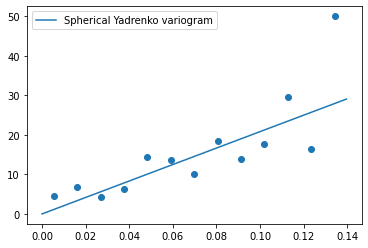

In [53]:
model = gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS)
model.fit_variogram(bin_c, vario, nugget=False)
ax = model.plot("vario_yadrenko", x_max=bins[-1])
ax.scatter(bin_c, vario)
print(model)

In [54]:
import rasterio
# read all the data from the first band
#dat = rasterio.open(r'./data/DEM_MONTPELLIER.tiff')
dat = rasterio.open(r'./data/DEM_MA_3.tiff')
z = dat.read()[0]

def get_elevation(lat, lon):
    idx = dat.index(lon, lat, precision=1E-6)    
    return z[idx]

In [55]:
uk = gs.krige.Universal(
    model=model,
    cond_pos=(gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]),
    cond_val=gdf_measures_cycle["temp"],
    drift_functions=get_elevation
)

In [56]:
g_lat = np.arange(lat_sw, lat_ne, 0.1)
g_lon = np.arange(lon_sw, lon_ne, 0.1)

uk.set_pos((g_lat, g_lon), mesh_type="structured")
uk(return_var=False, store="temp_field")
uk(only_mean=True, store="mean_field")

KeyboardInterrupt: 

In [ ]:
df = gpd.read_file("./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp")  # only use the simplest polygon
border = df["geometry"].values[0]
np.savetxt("./data/mar_borders/mar_borders.txt", list(border.exterior.coords))
border = np.loadtxt("./data/mar_borders/mar_borders.txt")

min=-10
max=45

levels = np.linspace(min, max, (max-min+1))
fig, ax = plt.subplots(1, 3, figsize=[20, 8], sharey=True)
sca = ax[0].scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], c=gdf_measures_cycle["temp"], vmin=min, vmax=max, cmap="nipy_spectral")
co1 = ax[1].contourf(g_lon, g_lat, uk["temp_field"], levels, cmap="nipy_spectral")
co2 = ax[2].contourf(g_lon, g_lat, uk["mean_field"], levels, cmap="nipy_spectral")




df_2 = gpd.read_file("./data/mar_borders/mar_admbnda_adm1_unhcr_20201203.shp")  # only use the simplest polygon
for j in range(len(df_2)):
    border_2 = df_2["geometry"].values[j]
    np.savetxt("./data/mar_borders/mar_borders_2.txt", list(border_2.exterior.coords))
    border_2 = np.loadtxt("./data/mar_borders/mar_borders_2.txt")
    [ax[i].plot(border_2[:, 0], border_2[:, 1], color="gray", linewidth=0.5) for i in range(3)]

[ax[i].plot(border[:, 0], border[:, 1], color="k") for i in range(3)]

#[ax[i].set_xlim([5, 16]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(3)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title("Temperature observations at 2m\nfrom DWD (2020-06-09 12:00)")
ax[1].set_title("Interpolated temperature\nwith altitude drift")
ax[2].set_title("Estimated mean drift\nfrom Universal Kriging")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.1, pad=0.2)
fig.colorbar(co2, ax=ax, **fmt).set_label("T in [°C]")

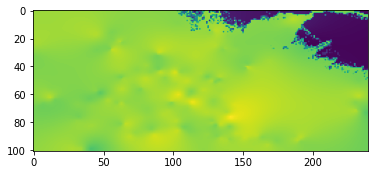

In [ ]:
plt.imshow(uk["temp_field"])

In [ ]:
elev = np.empty((len(g_lat), len(g_lon)), dtype=float)
for idx, a0 in enumerate(g_lat) :
    for jdx, b0 in enumerate(g_lon) :
        try:
            elev[idx, jdx] = get_elevation(a0, b0)
        except:
            pass

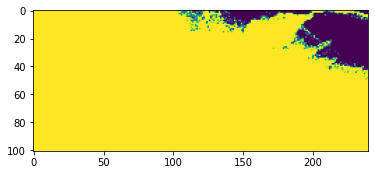

In [ ]:
plt.imshow(elev)

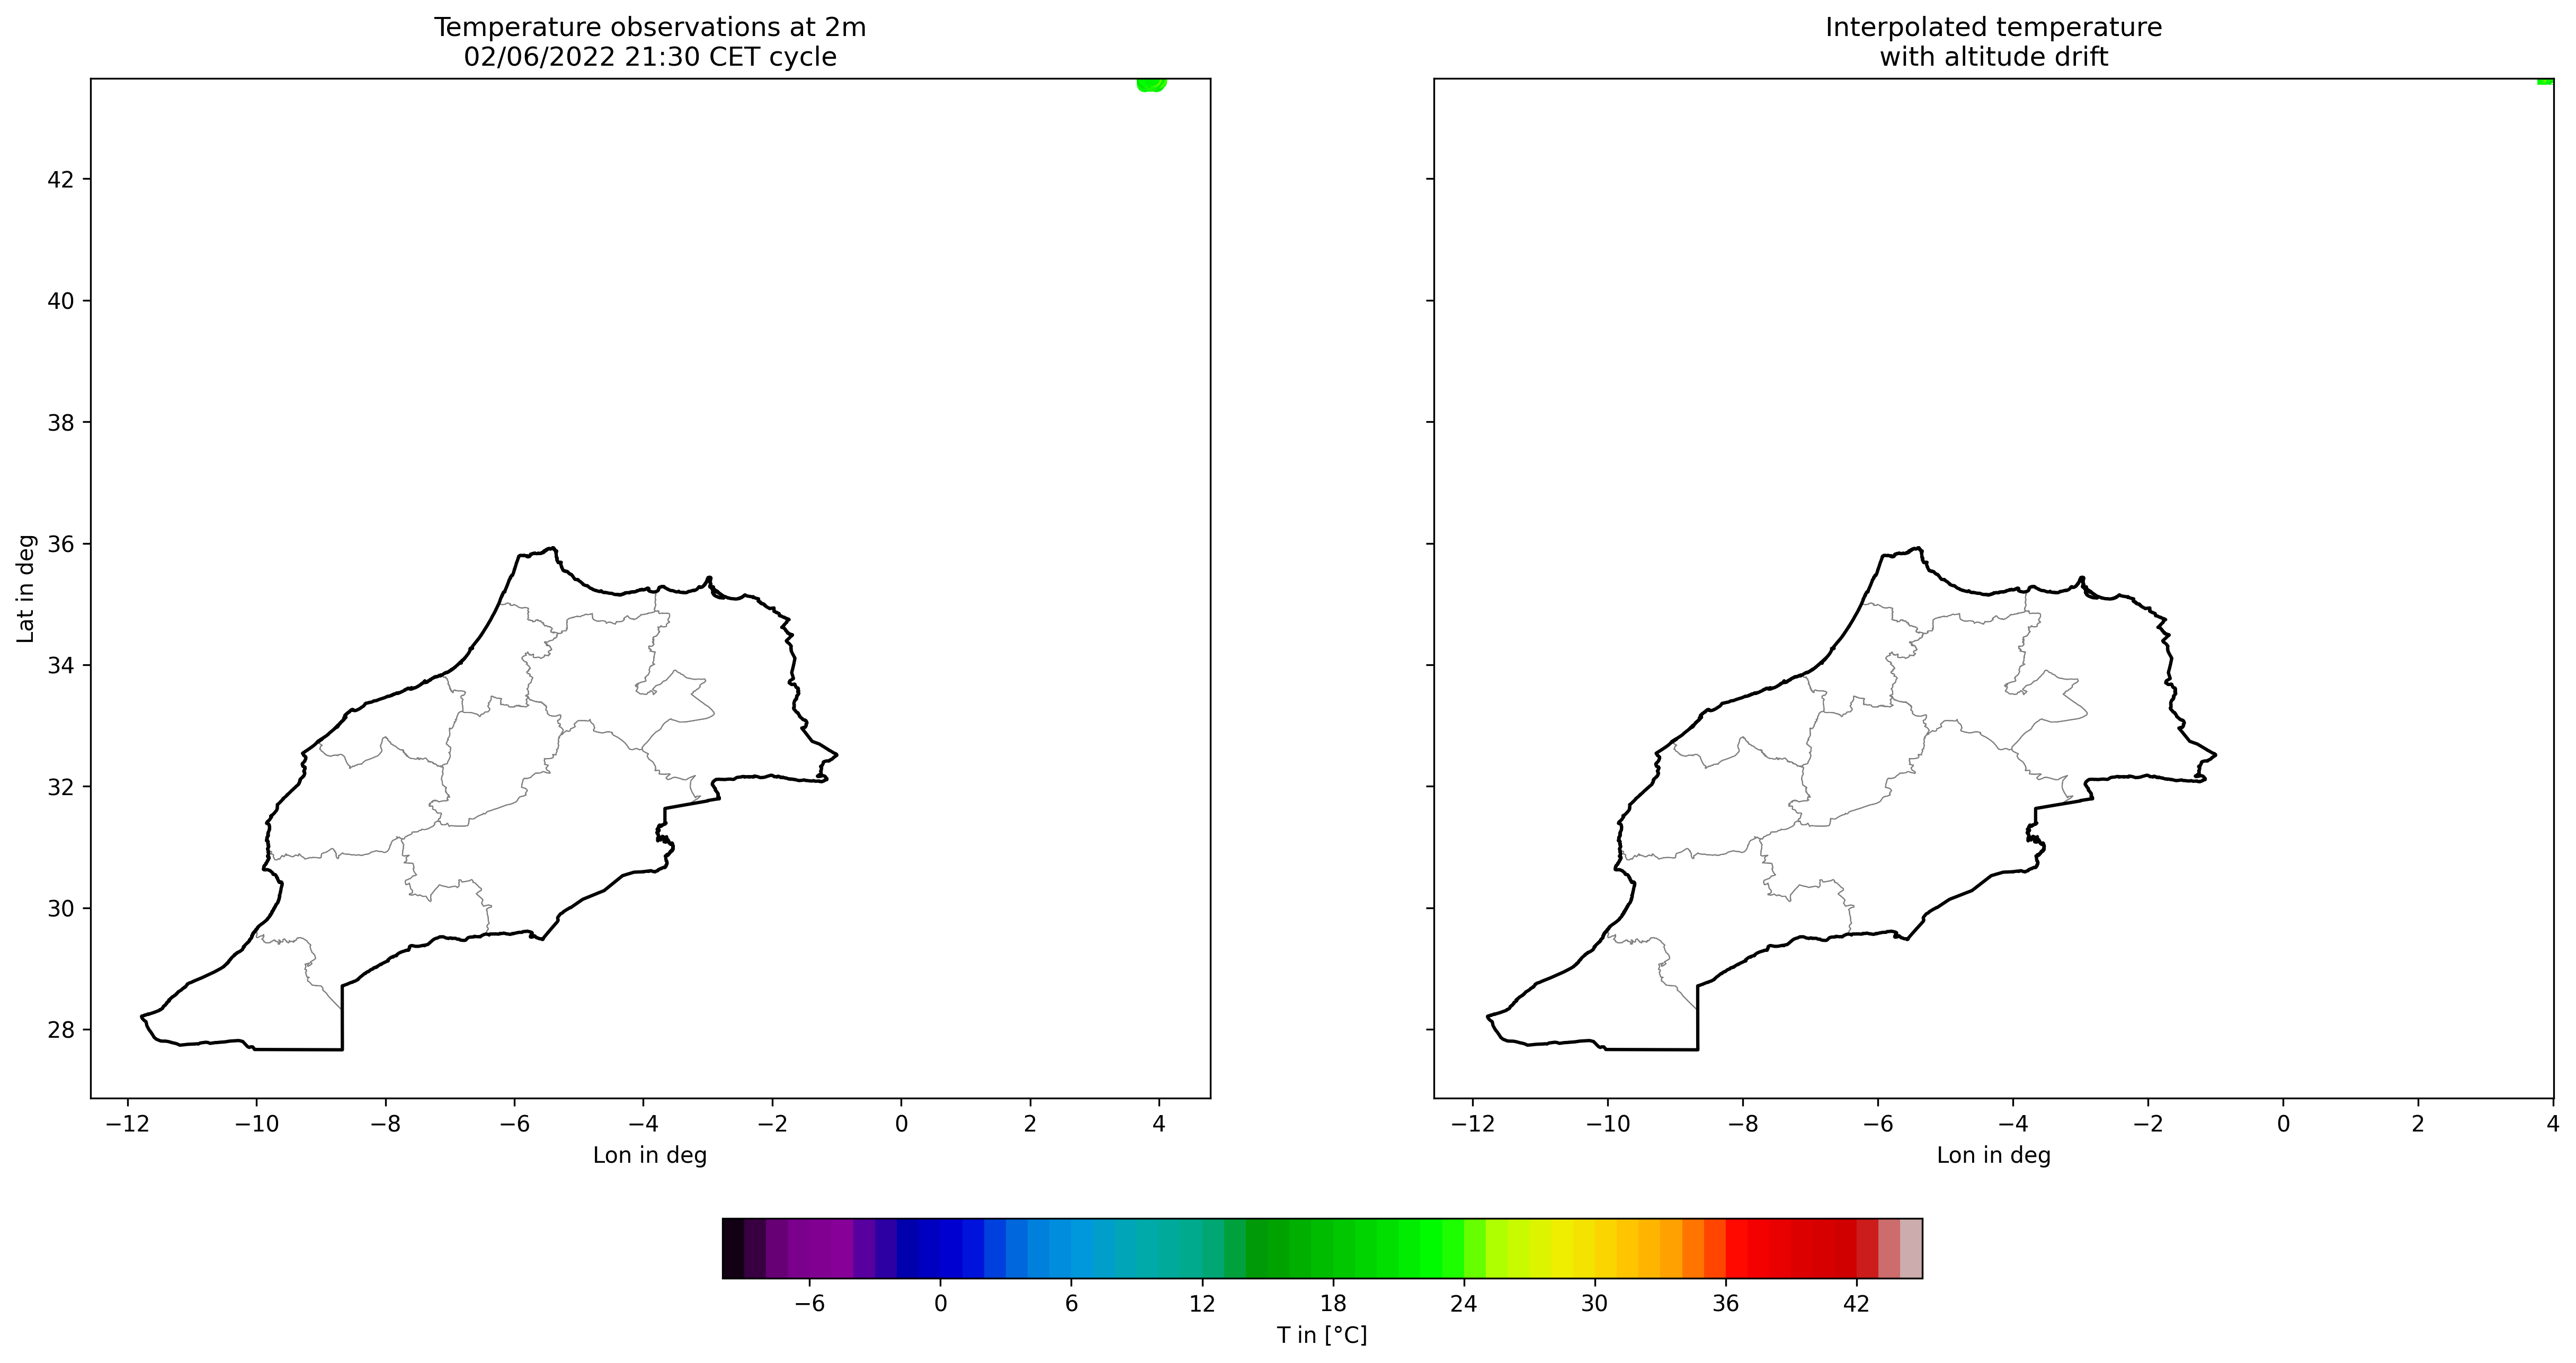

In [ ]:
# plotting main figure

min=-10
max=45

levels = np.linspace(min, max, (max-min+1))
fig, ax = plt.subplots(1, 2, figsize=[20, 10], dpi=300, sharey=True)
sca = ax[0].scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], c=gdf_measures_cycle["temp"], vmin=min, vmax=max, cmap="nipy_spectral")
co1 = ax[1].contourf(g_lon, g_lat, np.where(elev!=0,uk["temp_field"],np.nan), levels, cmap="nipy_spectral")
# co2 = ax[2].contourf(g_lon, g_lat, uk["mean_field"], levels, cmap="nipy_spectral")


df_2 = gpd.read_file("./data/mar_borders/mar_admbnda_adm1_unhcr_20201203.shp")  # only use the simplest polygon
for j in range(len(df_2)):
    border_2 = df_2["geometry"].values[j]
    np.savetxt("./data/mar_borders/mar_borders_2.txt", list(border_2.exterior.coords))
    border_2 = np.loadtxt("./data/mar_borders/mar_borders_2.txt")
    [ax[i].plot(border_2[:, 0], border_2[:, 1], color="gray", linewidth=0.5) for i in range(2)]

[ax[i].plot(border[:, 0], border[:, 1], color="k") for i in range(2)]

#[ax[i].set_xlim([5, 16]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(2)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title("Temperature observations at 2m\n"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d/%m/%Y %H:%M CET cycle"))
ax[1].set_title("Interpolated temperature\nwith altitude drift")
# ax[2].set_title("Estimated mean drift\nfrom Universal Kriging")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.05, pad=0.1)
fig.colorbar(co1, ax=ax, **fmt).set_label("T in [°C]")
plt.savefig("Morocco_"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d-%m-%Y_%H:%M_CET_cycle")+".jpg", dpi=300)

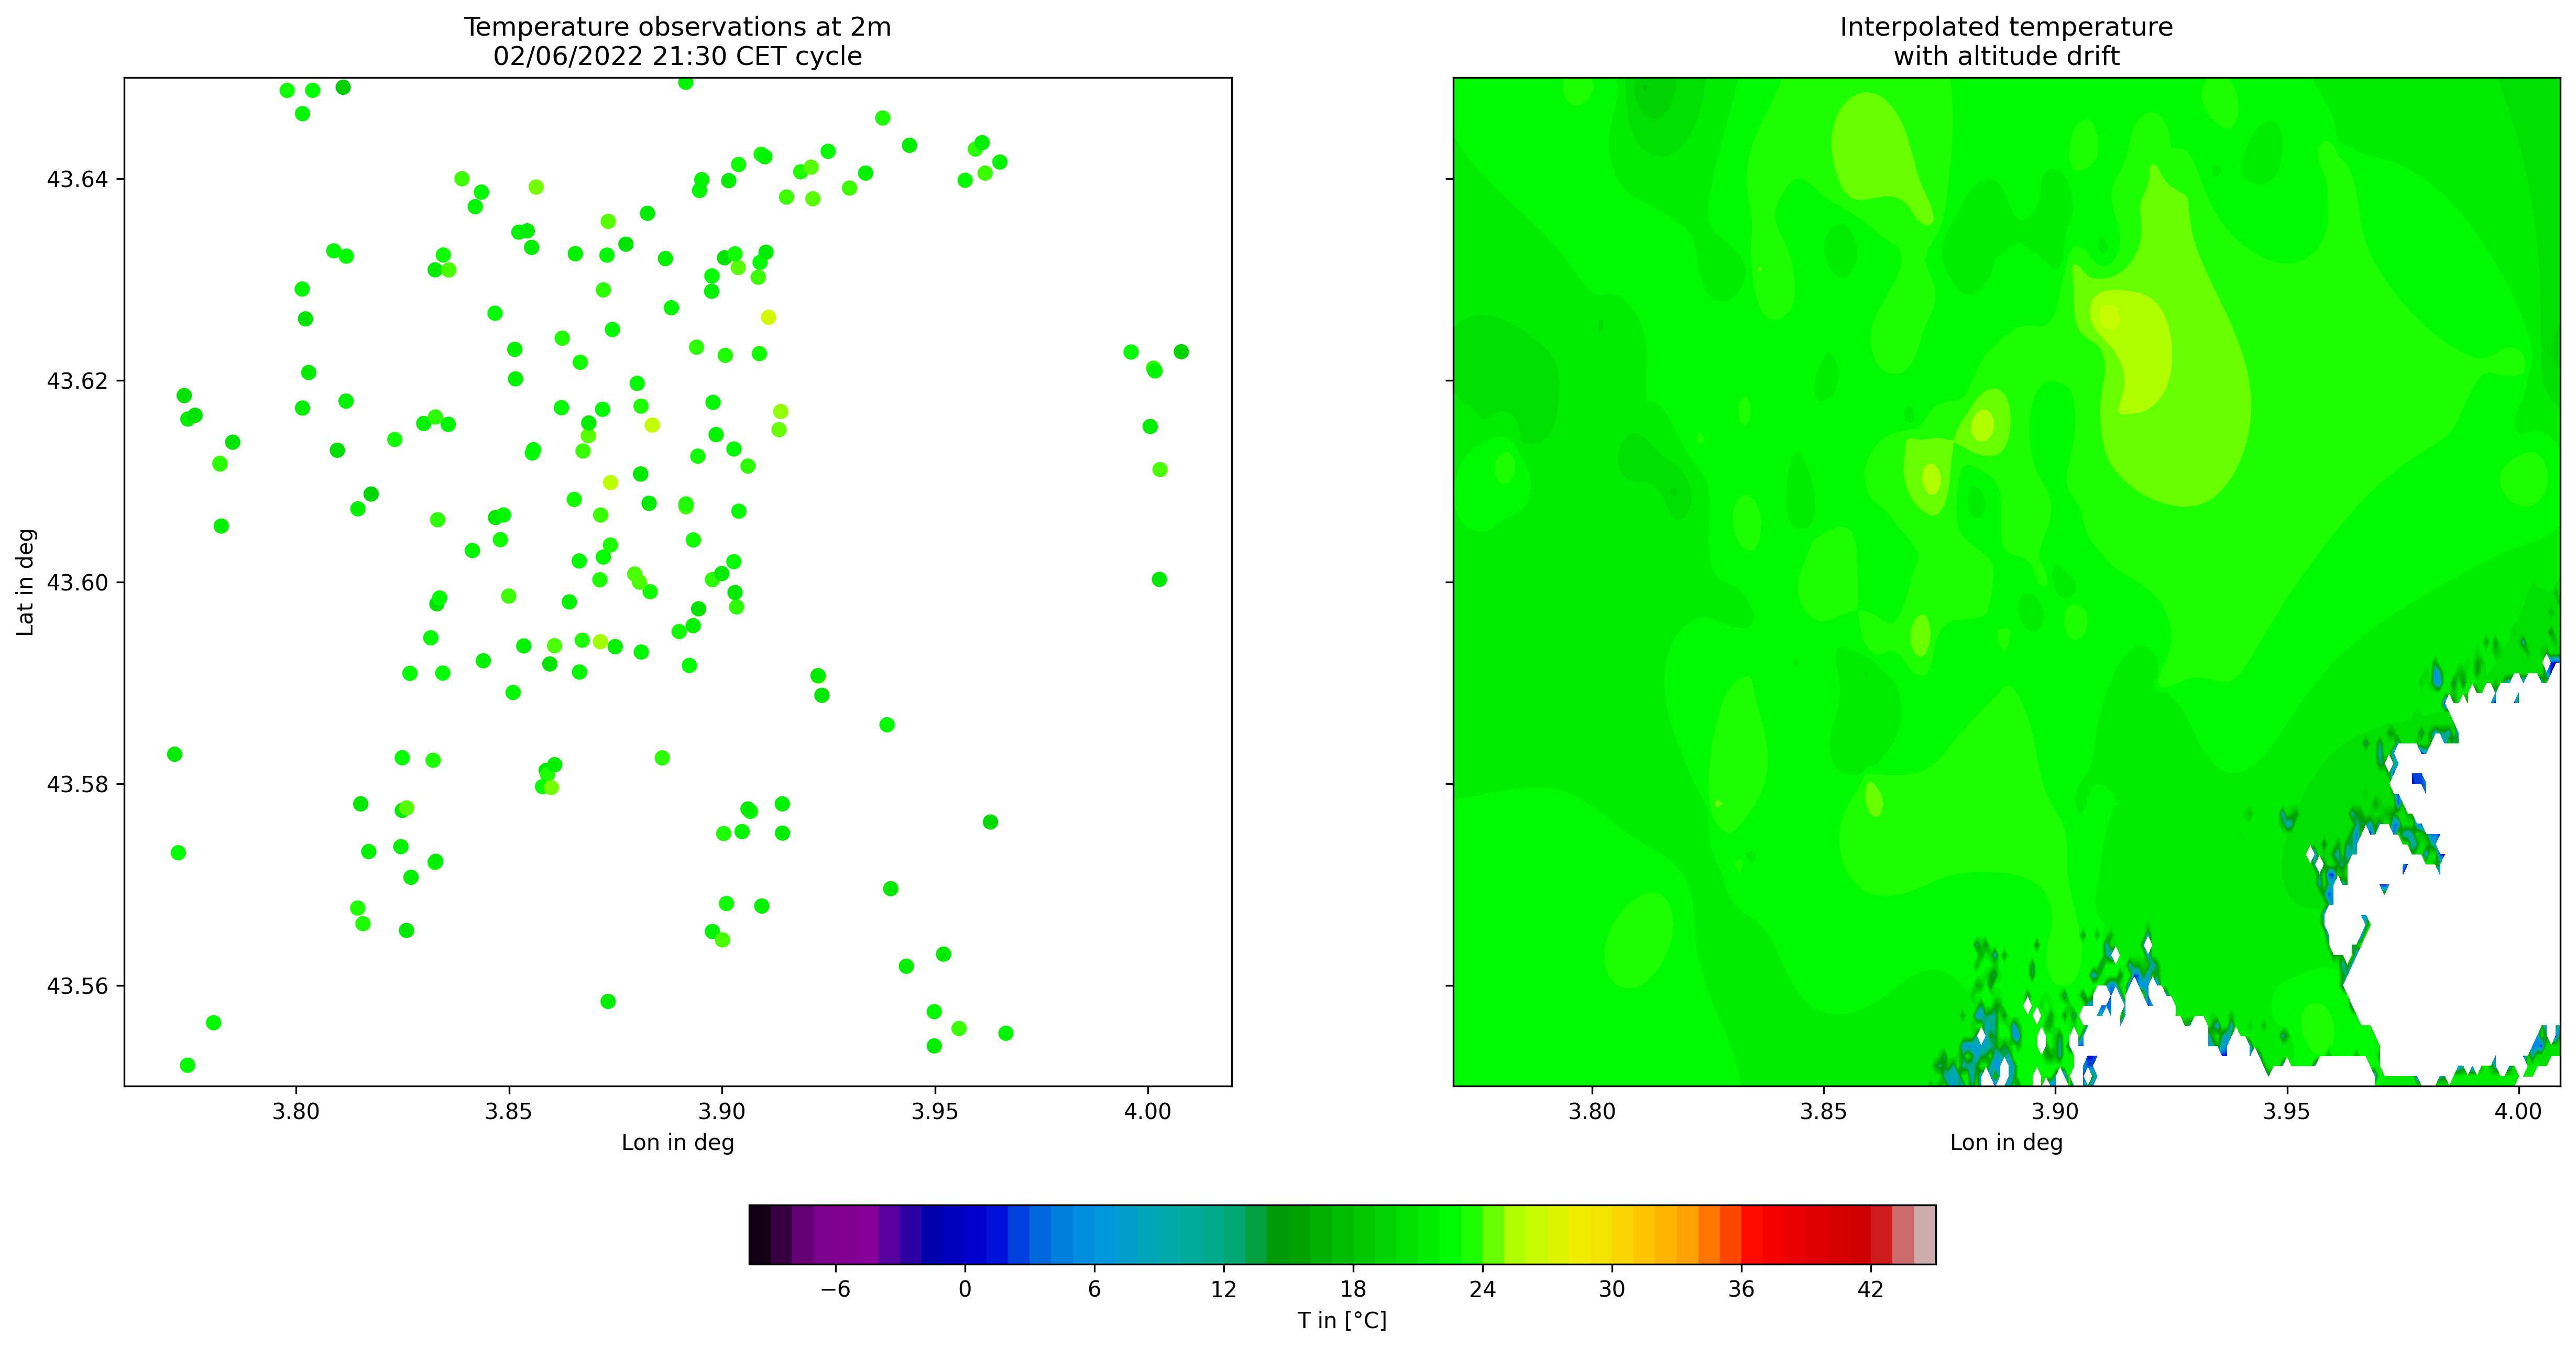

In [47]:
# plotting main figure

min=-10
max=45

levels = np.linspace(min, max, (max-min+1))
fig, ax = plt.subplots(1, 2, figsize=[20, 10], dpi=300, sharey=True)
sca = ax[0].scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], c=gdf_measures_cycle["temp"], vmin=min, vmax=max, cmap="nipy_spectral")
co1 = ax[1].contourf(g_lon, g_lat, np.where(elev!=0,uk["temp_field"],np.nan), levels, cmap="nipy_spectral")
# co2 = ax[2].contourf(g_lon, g_lat, uk["mean_field"], levels, cmap="nipy_spectral")

"""
df_2 = gpd.read_file("./data/mar_borders/mar_admbnda_adm1_unhcr_20201203.shp")  # only use the simplest polygon
for j in range(len(df_2)):
    border_2 = df_2["geometry"].values[j]
    np.savetxt("./data/mar_borders/mar_borders_2.txt", list(border_2.exterior.coords))
    border_2 = np.loadtxt("./data/mar_borders/mar_borders_2.txt")
    [ax[i].plot(border_2[:, 0], border_2[:, 1], color="gray", linewidth=0.5) for i in range(2)]
"""

#[ax[i].plot(border[:, 0], border[:, 1], color="k") for i in range(2)]

#[ax[i].set_xlim([5, 16]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(2)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title("Temperature observations at 2m\n"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d/%m/%Y %H:%M CET cycle"))
ax[1].set_title("Interpolated temperature\nwith altitude drift")
# ax[2].set_title("Estimated mean drift\nfrom Universal Kriging")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.05, pad=0.1)
fig.colorbar(co1, ax=ax, **fmt).set_label("T in [°C]")
plt.savefig("Morocco_"+pd.to_datetime(df_measures_cycle.time.unique()[0]).strftime("%d-%m-%Y_%H:%M_CET_cycle")+".jpg", dpi=300)

# code snippets

In [147]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
# https://github.com/Jorl17/open-elevation/blob/master/docs/api.md

import json
from tqdm import tqdm

gdf_measures_cycle["elevation"]=np.nan

for i in tqdm(range(len(gdf_measures_cycle))):
    response = requests.get("https://api.open-elevation.com/api/v1/lookup?locations="+str(gdf_measures_cycle["latitude_deg"].iloc[i])+","+str(gdf_measures_cycle["longitude_deg"].iloc[i])).text
    response_info = json.loads(response)
    gdf_measures_cycle["elevation"].iloc[i] = response_info["results"][0]["elevation"]


  0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_693/1399882134.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 72/72 [00:15<00:00,  4.55it/s]


## Universal + drift 1

In [ ]:
import gstools as gs

# estimating variogram

bin_center, gamma = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"])
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

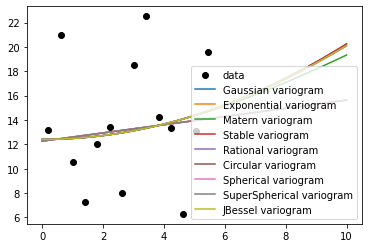

In [ ]:
bins = np.arange(40)
bin_center, gamma = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"])

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=10, ax=ax)
    scores[model] = r2

In [ ]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.        Gaussian: 0.00043523
     2.          Stable: 0.00043458
     3.         JBessel: 0.00040694
     4.        Rational: 0.00039605
     5.          Matern: 0.00019916
     6.       Spherical: -0.0058689
     7.        Circular: -0.005869
     8.  SuperSpherical: -0.0058694
     9.     Exponential: -0.005871


## nniversal + drift including latlon

Spherical(latlon=True, var=8.02, len_scale=1.44e+03, nugget=9.3, rescale=6.37e+03)


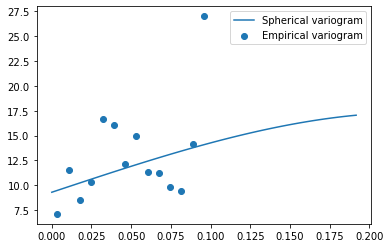

In [ ]:
emp_v = gs.vario_estimate((gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"]), gdf_measures_cycle["temp"], latlon=True)
sph = gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS)
sph.fit_variogram(*emp_v, sill=np.var(gdf_measures_cycle["temp"]))
ax = sph.plot(x_max=2 * np.max(emp_v[0]))
ax.scatter(*emp_v, label="Empirical variogram")
ax.legend()
print(sph)

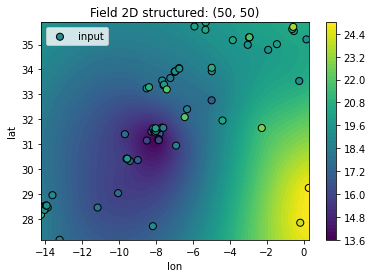

In [ ]:
# enclosing box for data points
grid_lon = np.linspace(np.min(gdf_measures_cycle["longitude_deg"]), np.max(gdf_measures_cycle["longitude_deg"]))
grid_lat = np.linspace(np.min(gdf_measures_cycle["latitude_deg"]), np.max(gdf_measures_cycle["latitude_deg"]))
# ordinary kriging
krige = gs.krige.Ordinary(sph, (gdf_measures_cycle["latitude_deg"], gdf_measures_cycle["longitude_deg"]), gdf_measures_cycle["temp"])
krige((grid_lat, grid_lon), mesh_type="structured")
ax = krige.plot()
# plotting lat on y-axis and lon on x-axis
ax.scatter(gdf_measures_cycle["longitude_deg"], gdf_measures_cycle["latitude_deg"], 50, c= gdf_measures_cycle["temp"], edgecolors="k", label="input")
ax.legend()

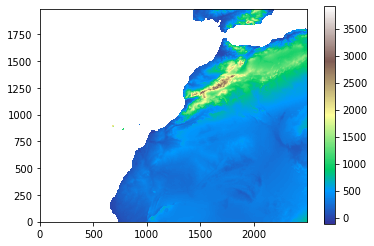

In [ ]:
plt.imshow(np.where(np.flip(z,axis=0)==0,np.nan,np.flip(z,axis=0)), cmap="terrain", origin="lower")
plt.colorbar()